In [1]:
!pip3 install -r /data/pathology/users/thijs/nnunet-for-pathology/requirements.txt
!pip3 install git+https://github.com/thijsgelton/nnunet-for-pathology

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.0/584.0 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.8/409.8 kB 57.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.1/151.1 kB 41.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.0/79.0 kB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.3/199.3 kB 50.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.4/103.4 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.1/64.1 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.0/232.0 kB 49.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.0/297.0 kB 48.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.5/218.5 kB 46.0 MB/s eta 0:00:00
  Preparing metadata (setup.py)

In [31]:
from typing import Any, List
import torch
from multiscale.models.YclassRes18Net import YclassRes18Net
import torch
from pytorch_lightning import LightningModule
from torchmetrics import MaxMetric
from torchmetrics.classification.accuracy import Accuracy
from src.datamodules.wsi_datamodule import WholeSlideDataModule
from wholeslidedata.source.files import WholeSlideImageFile
from wholeslidedata.iterators import create_batch_iterator
from src.utils.metrics import Dice
from pytorch_lightning import (
    Callback,
    LightningDataModule,
    LightningModule,
    Trainer,
    seed_everything,
)
from pytorch_lightning.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
    RichModelSummary
)


import warnings

# or to ignore all warnings that could be false positives
from pytorch_lightning.utilities.warnings import PossibleUserWarning
warnings.filterwarnings("ignore", category=PossibleUserWarning)

In [32]:
class YnetLitModule(LightningModule):
    """Example of LightningModule for MNIST classification.

    A LightningModule organizes your PyTorch code into 5 sections:
        - Computations (init).
        - Train loop (training_step)
        - Validation loop (validation_step)
        - Test loop (test_step)
        - Optimizers (configure_optimizers)

    Read the docs:
        https://pytorch-lightning.readthedocs.io/en/latest/common/lightning_module.html
    """

    def __init__(
        self,
        net: torch.nn.Module,
        lr: float = 0.001,
        weight_decay: float = 0.0005,
    ):
        super().__init__()

        # this line allows to access init params with 'self.hparams' attribute
        # it also ensures init params will be stored in ckpt
        self.save_hyperparameters(logger=False, ignore=['net'])

        self.net = net

        # loss function
        self.loss_fn_seg = torch.nn.CrossEntropyLoss()
        self.loss_fn_class = torch.nn.CrossEntropyLoss()

        # use separate metric instance for train, val and test step
        # to ensure a proper reduction over the epoch
        self.train_dice = Dice(num_classes=6)
        self.val_dice = Dice(num_classes=6)
        
        self.class_name_to_onehot = {
            "Normal": torch.Tensor([1,0,0,0,0,0]),
            "Hyperplasia_without_atypia": torch.Tensor([0,1,0,0,0,0]),
            "Hyperplasia_with_atypia": torch.Tensor([0,0,1,0,0,0]),
            "Carcinoma": torch.Tensor([0,0,0,1,0,0])
        }
        self.val_dice_best = MaxMetric()
        

    def forward(self, x: torch.Tensor):
        return self.net(*x)

    def on_train_start(self):
        # by default lightning executes validation step sanity checks before training starts,
        # so we need to make sure val_dice_best doesn't store accuracy from these checks
        self.val_dice_best.reset()

    def step(self, batch: Any):
        x, y, info = batch
        y_class_true = self.create_class_label(y, info)
        y_seg_true = y[:, 0].type(torch.DoubleTensor).to(device=self.device).permute(0, 3, 1, 2)
        
        x = tuple([x[:, 0].permute(0, 3, 1, 2), x[:, 1].permute(0, 3, 1, 2)])
        
        seg_logits, class_logits = self.forward(x)
        loss = self.hybrid_loss(seg_logits, y_seg_true, class_logits, y_class_true)
        preds = torch.argmax(seg_logits, dim=1)
        return loss, preds, y_seg_true

    def training_step(self, batch: Any, batch_idx: int):
        loss, preds, targets = self.step(batch)

        # log train metrics
        dice = self.train_dice(preds, targets)
        self.log("train/loss", loss, on_step=False, on_epoch=True, prog_bar=False)
        # self.log("train/dice", dice, on_step=False, on_epoch=True, prog_bar=True)

        # we can return here dict with any tensors
        # and then read it in some callback or in `training_epoch_end()` below
        # remember to always return loss from `training_step()` or else backpropagation will fail!
        return {"loss": loss, "preds": preds, "targets": targets}

    def training_epoch_end(self, outputs: List[Any]):
        self.train_dice.reset()

    def validation_step(self, batch: Any, batch_idx: int):
        loss, preds, targets = self.step(batch)

        # log val metrics
        dice = self.val_dice(preds, targets)
        self.log("val/loss", loss, on_step=False, on_epoch=True, prog_bar=False)
        # self.log("val/dice", dice, on_step=False, on_epoch=True, prog_bar=True)

        return {"loss": loss, "preds": preds, "targets": targets}

    def validation_epoch_end(self, outputs: List[Any]):
        dice = self.val_dice.compute()  # get val accuracy from current epoch
        self.val_dice_best.update(dice)
        # self.log("val/dice_best", self.val_dice_best.compute(), on_epoch=True, prog_bar=True)        
        self.val_dice.reset()

        
    def hybrid_loss(self, y_pred_seg, y_true_seg, y_pred_class, y_true_class):
        print(y_pred_seg.shape, y_true_seg.shape, y_pred_class.shape, y_true_class.shape)
        loss_seg = self.loss_fn_seg(y_pred_seg, y_true_seg)
        loss_class = self.loss_fn_class(y_pred_class, y_true_class)
        
        loss = loss_seg + loss_class
        return loss
        
    def create_class_label(self, y, info):
        associations = self.trainer.train_dataloader.dataset.datasets.iterator.dataset._associations
        y_class_true = torch.zeros(y.shape[0], y.shape[-1], device=self.device)
        for i in range(y.shape[0]):
            class_name = associations[info['sample_references'][0]['reference'].file_key][WholeSlideImageFile][0].original_path.split("/")[-2]
            y_class_true[i] = self.class_name_to_onehot[class_name]
        return y_class_true
    
        
    def configure_optimizers(self):
        """Choose what optimizers and learning-rate schedulers to use in your optimization.
        Normally you'd need one. But in the case of GANs or similar you might have multiple.

        See examples here:
            https://pytorch-lightning.readthedocs.io/en/latest/common/lightning_module.html#configure-optimizers
        """
        return torch.optim.Adam(
            params=self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay
        )


In [33]:
datamodule = WholeSlideDataModule(user_train_config="train_config.yml", user_val_config="valid_config.yml", user_test_config="test_config.yml", num_classes=6, num_workers=6, return_info=True)

In [34]:
trainer = Trainer(gpus=1, callbacks=[
    ModelCheckpoint(monitor="val/dice", mode="max", save_top_k=1, save_last=True, verbose=True, dirpath="checkpoints/", filename="epoch_{epoch:03d}", auto_insert_metric_name=False),
    EarlyStopping(monitor="val/dice", mode="max", patience=10, min_delta=0)
], max_epochs=50, min_epochs=50, num_sanity_val_steps=0, )

Multiprocessing is handled by SLURM.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [35]:
num_channels = 3

# and a basic configurate might, such as, for instance
cfg = {
    'num_classes': 6,
    'num_channels': num_channels,
    'activation_function': 'ReLU',
    'num_base_featuremaps': 64,
    'encoder_featuremap_delay': 2,
    'decoder_featuremaps_out': [512, 256, 256, 128, -1],
    'conv_norm_type': 'None',
    'depth_levels_down_main': [[2, 3], [0, 3], [0, 1], [0, 1], [0, 1]],  # [Convs,Res] each
    # 'depth_levels_down_side': [[2, 3], [0, 3], [0, 1], [0, 1], [0, 1]],  # [Convs,Res] each
    'depth_levels_down_tail': [[2, 3], [0, 3], [0, 1], [0, 1], [0, 1]],  # [Convs,Res] each
    'depth_levels_up': [1, 1, 1, 1, 1],  # Convs
    'depth_bottleneck': [0, 0, 0],  # [Conv,Res,Conv]
    'internal_prediction_activation': 'None',  # Softmax, Sigmoid or None. None for use with BCEWithLogitsLoss etc.
}

# we can then instantiate and apply an examplary multi-scale model using the syntax
model =  YclassRes18Net(cfg=cfg)

In [36]:
lit_model_module = YnetLitModule(net=model)

In [37]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [38]:
trainer.fit(model=lit_model_module, datamodule=datamodule)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
mode = "training"

loss_fn_seg = torch.nn.CrossEntropyLoss()
loss_fn_class = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.00001, momentum=0.9)

epochs = 30

losses = []
with create_batch_iterator(mode=mode,user_config='./train_config.yml',cpus=4,return_info=True) as training_iterator: 
    for i in tqdm(range(1000)):
        x_batch, y_batch, info = next(training_iterator)
        # y_batch = y_batch.argmax(axis=-1)
        # fig, axs = plt.subplots(4, 3, figsize=(15, 10))
        # axs[0][0].imshow(x_batch[0, 0])
        # axs[0][1].imshow(x_batch[0, 1])
        # axs[0][2].imshow(x_batch[0, 2])
        # axs[1][0].imshow(y_batch[0, 0])
        # axs[1][1].imshow(y_batch[0, 1])
        # axs[1][2].imshow(y_batch[0, 2])
        # axs[2][0].imshow(x_batch[1, 0])
        # axs[2][1].imshow(x_batch[1, 1])
        # axs[2][2].imshow(x_batch[1, 2])
        # axs[3][0].imshow(y_batch[1, 0])
        # axs[3][1].imshow(y_batch[1, 1])
        # axs[3][2].imshow(y_batch[1, 2])
        # plt.show()
        y_batch_class = torch.zeros(y_batch.shape[0], y_batch.shape[-1])
        for i in range(y_batch.shape[0]):
            y_batch_class[i] = torch.from_numpy(np.array(class_name_to_onehot[training_iterator.dataset._associations[info['sample_references'][0]['reference'].file_key][WholeSlideImageFile][0].orginal_path.split("/")[-2]]))

        image_patch = tuple([
            torch.from_numpy(x_batch[:, 0].transpose(0, 3, 1, 2).astype("float32")).to(device="cuda"),
            torch.from_numpy(x_batch[:, 1].transpose(0, 3, 1, 2).astype("float32")).to(device="cuda"),
            torch.from_numpy(x_batch[:, 2].transpose(0, 3, 1, 2).astype("float32")).to(device="cuda")
        ])
        
        y_batch = torch.from_numpy(y_batch[:, 0].transpose(0, 3, 1, 2).astype("float")).to(device="cuda")

        segmentation_logits, classification_logits = model(*image_patch)
        
        # print(segmentation_logits, classification_logits)
        
        loss_seg = loss_fn_seg(segmentation_logits, y_batch)
        loss_class = loss_fn_class(classification_logits, y_batch_class.to(device="cuda"))
        
        # print(loss_seg, loss_class)
        loss = loss_seg + loss_class
        loss.backward()

        loss_scalar = loss.cpu().detach().item()
        # if i % 10:
        #     print(loss_scalar)
        losses.append(loss_scalar)

        optimizer.step()  
    
        
training_iterator.stop()

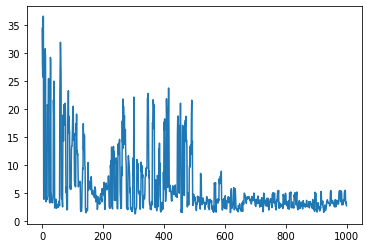

In [9]:
plt.plot(losses)